# 2_Gaussian_Discriminant_Analysis

In [9]:
import torch
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import matplotlib.pyplot as plt # Needs for Ploting
%matplotlib inline
torch.manual_seed(888)    # reproducible

## Prepare Data

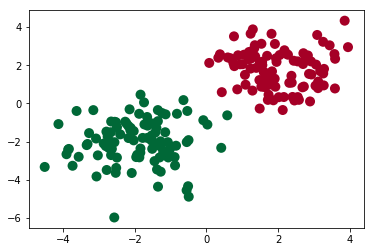

tensor([[ 1.9233,  0.8776,  0.0000],
        [ 1.8682,  0.1658,  0.0000],
        [ 2.5491,  0.3336,  0.0000],
        [ 1.0085,  2.0562,  0.0000],
        [ 1.6976,  0.9487,  0.0000],
        [ 1.4894,  2.1460,  0.0000],
        [ 0.3763,  2.5749,  0.0000],
        [ 3.4396,  3.0438,  0.0000],
        [ 1.9560,  2.1769,  0.0000],
        [ 0.7679,  3.5142,  0.0000],
        [ 2.1770,  2.7858,  0.0000],
        [ 3.2745,  0.9453,  0.0000],
        [ 1.7331,  1.4741,  0.0000],
        [ 1.6297,  0.8627,  0.0000],
        [ 1.2333,  3.6529,  0.0000],
        [ 1.6571,  1.1602,  0.0000],
        [ 1.0911,  0.9823,  0.0000],
        [ 1.6068,  0.8801,  0.0000],
        [ 3.1155,  0.8023,  0.0000],
        [ 0.7772,  1.9543,  0.0000],
        [ 1.2300,  1.8254,  0.0000],
        [ 2.4562,  0.1563,  0.0000],
        [ 1.5602,  2.0071,  0.0000],
        [ 1.8164,  3.6474,  0.0000],
        [ 1.8297,  1.6803,  0.0000],
        [ 2.1608,  0.3367,  0.0000],
        [ 1.7141,  0.1869,  0.0000],
 

In [10]:
# make fake data
n_data = torch.ones(100, 2)

x0 = torch.normal(2*n_data, 1)        # class0 x data (tensor), shape=(100, 2)   mu=(2,2), var =1
y0 = torch.zeros(100,1)               # class0 y data (tensor), shape=(100, 1)

x1 = torch.normal(-2*n_data, 1)       # class1 x data (tensor), shape=(100, 2)   mu=(-2,2), var=1
y1 = torch.ones(100,1)                # class1 y data (tensor), shape=(100, 1)

x = torch.cat((x0, x1)).type(torch.FloatTensor)    # shape (200, 2) FloatTensor = 32-bit floating
y = torch.cat((y0, y1)).type(torch.FloatTensor)    # shape (200, 1) FloatTensor = 32-bit integer

plt.scatter(x.data.numpy()[:,0], x.data.numpy()[:,1], c=y.squeeze().numpy(), s=100, lw=0, cmap='RdYlGn')
plt.show()

torch.cat((x, y),dim=1)

## GDA Model and Parameters Estimation

### $p(y=1) = \phi = \frac{1}{m}\sum_{i=1}^{m}{1\{y^{(i)}=1}\}$  

In [11]:
phi1 = (y==1).sum().float()/200
phi0 = 1-phi1
phi1

tensor(0.5000)

### $ \mu_0 = \frac{
\sum_{i=1}^{m}{1\{y^{(i)}=0}\} x^{(i)} } {
\sum_{i=1}^{m}{1\{y^{(i)}=0}\} } $

In [12]:
mu0 = x[(y==0).squeeze(),:].mean(0,keepdim=True)
mu0

tensor([[1.9724, 1.7607]])

### $\mu_1 = \frac{
\sum_{i=1}^{m}{1\{y^{(i)}=1}\} x^{(i)} } {
\sum_{i=1}^{m}{1\{y^{(i)}=1}\} } $

In [13]:
mu1 = x[(y==1).squeeze(),:].mean(0,keepdim=True)
mu1

tensor([[-1.9262, -2.0058]])

### $\Sigma = diag(1,1)$

In [14]:
sigma0 = torch.ones(1,2)
sigma1 = torch.ones(1,2)
sigma0

tensor([[1., 1.]])

## Prediction (Test)

In [15]:
a_sample = torch.ones(1, 2)
x_new = torch.normal(-2*a_sample, 1)        # sample x_new ~ Gaussian( mu=(2,2), var=diag(1,1))  (class0) 
x_new

tensor([[-1.1386, -3.4529]])

### Gaussian Distribution
### $ p(x;\mu, \sigma)=\frac{1}{\sqrt{2\pi|\Sigma|} }\exp\left(-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)\right) $


In [24]:
K=1
def get_k_likelihoods(X, mu, var):
    if var.eq(0).any(): raise Exception('variances must be nonzero')
    sigma_inv = 1./var                                                        # (K, features)
    coeff = 1./((2*np.pi*var).prod(dim=1)).sqrt()                             # (K )
    likelihoods = coeff.view(K,1,1) * torch.exp(-0.5 *( (X-mu.unsqueeze(1))**2 @sigma_inv.unsqueeze(2)))  # @ is matrix multiplication
    return likelihoods.squeeze(2)

### likelihood $p(x|y=1) $

In [25]:
prob1 = get_k_likelihoods(x_new,mu1,sigma1)
prob1

tensor([[0.0410]])

### likelihood $p(x|y=0) $

In [26]:
prob0 = get_k_likelihoods(x_new,mu0,sigma0)
prob0

tensor([[1.5770e-09]])

### Decision Rule

### y=1 if $\frac{p(x|y=1)p(y=1)}{p(x|y=0)p(y=0)} > 1$

In [27]:
(prob1 * phi1) / (prob0 * phi0)  > 1

tensor([[1]], dtype=torch.uint8)

### Bayese Rule

## $p(y=1|x)=\frac{p(x|y=1)p(y=1)}{p(x|y=1)p(y=1) + p(x|y=0)p(y=0)}$

In [28]:
p1 = (prob1 * phi1) / ((prob1 * phi1)+(prob0 * phi0))
p1

tensor([[1.]])

In [29]:
1-p1

tensor([[0.]])

## Draw Sample from GDA Model

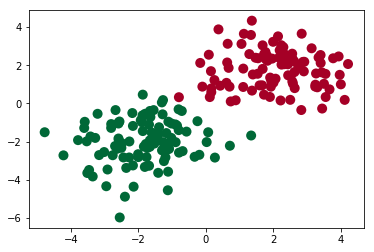

In [30]:
# make fake data
n_data = torch.ones(100, 2)

x0 = torch.normal(mu0.repeat(100,1).data, 1)        # class0 x data (tensor), shape=(100, 2)   mu=(2,2), var =1
y0 = torch.zeros(100,1)                             # class0 y data (tensor), shape=(100, 1)

x1 = torch.normal(mu1.repeat(100,1).data, 1)        # class1 x data (tensor), shape=(100, 2)   mu=(-2,2), var=1
y1 = torch.ones(100,1)                              # class1 y data (tensor), shape=(100, 1)

x_sample = torch.cat((x0, x1)).type(torch.FloatTensor)     # shape (200, 2) FloatTensor = 32-bit floating
y_sample = torch.cat((y0, y1)).type(torch.FloatTensor)     # shape (200, 1) FloatTensor = 32-bit integer

plt.scatter(x_sample.data.numpy()[:,0], x.data.numpy()[:,1], c=y_sample.squeeze().numpy(), s=100, lw=0, cmap='RdYlGn')
plt.show()